In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Step 1: Loading traditional Digit MNIST dataset

In [36]:
# I got error on downloading this dataset so I only use it online without downloading

#transform data into Tensor and normalize with mean = 0.5, standard deviation = 0.5 -> do lech chuan
transform = transforms.Compose([
    transforms.ToTensor() ,
    transforms.Normalize((0.5, 0.5 , 0.5),(0.5, 0.5 , 0.5)),
    transforms.Resize((28,28))
])


training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transform
)
training_data , valid_data = torch.utils.data.random_split(training_data , [0.8,0.2])

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform= transform
)

#after transform image become tensor and can only displayed using plt.imshow with img.squeeze()

Files already downloaded and verified
Files already downloaded and verified


In [37]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [38]:
# using plt to show the numbers and labels randomly 

# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(training_data), size=(1,)).item()
#     img , label= training_data[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray") #in order to use plt.imshow , must use img.squeeze()
# plt.show()

In [39]:
from torch.utils.data import DataLoader


epoch_num = 3
batch_size_train = 64
batch_size_test = 1000
l_r = 0.01
momentum = 0.9
log_interval = 100  #how often the training result being printed (1 time for every 100 batches)

random_seed = 10
torch.manual_seed(random_seed)


In [40]:
# for shuffling the dataset when we sample a minibatch in the training phase 

train_dataloader = DataLoader(training_data , batch_size = batch_size_train , shuffle= True)
valid_dataloader = DataLoader(valid_data , batch_size = batch_size_test , shuffle = False)
test_dataloader = DataLoader(test_data , batch_size= batch_size_test, shuffle = False )

data_loader = {'train':train_dataloader , 'valid':valid_dataloader , 'test':test_dataloader}

In [41]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.098232895..0.9000001].


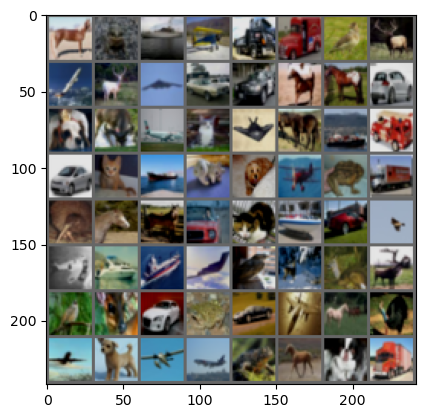

In [42]:
# to see a batch when DataLoader sampling, using next(iter(...)) #a batch is 64 figures size 1x28x28 and it's labels
train_features, train_labels = next(iter(train_dataloader))


#imshow redefinited function to display image using plt.imshow
def imshow(img):
    img = img/2 + 0.4
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_features))


# Step 2: Building CNN Lenet5 model 

In [43]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 6 , kernel_size= 5 , padding = 2)
        self.pool = nn.MaxPool2d(kernel_size= 2 , stride= 2 , padding=0 )
        self.conv2 = nn.Conv2d(in_channels= 6 , out_channels= 16 , kernel_size= 5 , stride= 1 , padding= 0)
        # self.pool2 = nn.MaxPool2d(kernel_size= 2 , stride= 2 , padding= 0 )
        self.fc1 = nn.Linear(16*5*5 , 120 )
        self.fc2 = nn.Linear(120 , 84)
        self.fc3 = nn.Linear(84,10)
        self._initialize_weights()

    #using Xavier initialization to prevent vanishing gradient when using relu activation function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x ):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x , 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [44]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer , step_size= 7 , gamma = 0.1)

# Step 3: Train the network 

In [45]:
import time

In [46]:
def train_model(model , criterion , optimizer , scheduler , num_epochs = 25):    
    since = time.time()
    best_acc = 0
    best_model_params_path = './cifar_lenet5.best.pth'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    for epoch in range(num_epochs):

        for phase in ['train' , 'valid']:
            running_loss = 0.0
            correct = 0 
            total = 0
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _ , prediction = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                total += labels.size(0)
                running_loss += loss.item()
                correct += torch.sum(prediction == labels.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = (running_loss)/total
            epoch_acc = correct / total 

            if phase == 'valid' and epoch_acc > best_acc:
                torch.save(model.state_dict(), best_model_params_path)
                best_acc = epoch_acc
        # print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {running_loss / len(train_dataloader)}, t loss: {}')

            if phase == 'train':
                print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {epoch}')
            else:
                print(f' valid correct percent : {epoch_acc:.2f}')
        
                

    time_last = time.time() - since
    print(f'Training complete in {time_last // 60:.0f}m {time_last % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


                



                

        # for inputs, labels in train_dataloader:
        #     inputs, labels = inputs.to(device), labels.to(device)
            
        #     optimizer.zero_grad()
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
            
        #     running_loss += loss.item()
        

        
        # print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {running_loss / len(train_dataloader)}, testing loss: {}')

    print('Finished Training')

In [47]:
# PATH = './cifar_net.pth'
# torch.save(lenet5.state_dict(), PATH)

In [48]:
# input, label = test_data[0]

# plt.imshow(input[0], cmap = "gray")
# plt.title(label)
# plt.show()


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model(model , optimizer=optimizer , criterion= criterion , scheduler= scheduler , num_epochs= 20).to(device)
model.eval() #use evaluation mode in order to stop using drop out
correct = 0
total = 0
with torch.no_grad(): #disable gradient calculating to saving memory
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #send to device to use cpu or gpu 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #Gets the predicted class by finding the index of the maximum value in the output tensor along dimension 1
        total += labels.size(0)
        for i in predicted:
            if predicted[i] == labels[i]:
                correct+=1
        
print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Epoch [1/20], training loss: 0.026631188637018202
 valid correct percent : 0.47
Epoch [2/20], training loss: 0.021441828334331513
 valid correct percent : 0.53
Epoch [3/20], training loss: 0.0193251615524292
 valid correct percent : 0.56
Epoch [4/20], training loss: 0.01793111796528101
 valid correct percent : 0.58
Epoch [5/20], training loss: 0.016873059557378292
 valid correct percent : 0.60
Epoch [6/20], training loss: 0.01584734142869711
 valid correct percent : 0.61
Epoch [7/20], training loss: 0.015091884814202785
 valid correct percent : 0.62
Epoch [8/20], training loss: 0.01225466919913888
 valid correct percent : 0.65
Epoch [9/20], training loss: 0.01168541371896863
 valid correct percent : 0.65
Epoch [10/20], training loss: 0.011404849742352962
 valid correct percent : 0.65
Epoch [11/20], training loss: 0.01116542606651783
 valid correct percent : 0.65
Epoch [12/20], training loss: 0.010966462329030037
 valid correct percent : 0.65
Epoch [13/20], training loss: 0.010779638145